In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [2]:
!wget -q -O detector.tflite -q https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

In [ ]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

In [16]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from google.colab.patches import cv2_imshow
import os
from PIL import Image




# STEP 2: Create a FaceDetector object.
base_options = python.BaseOptions(model_asset_path='detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)


def detect_face(folder_path,file_name):

  folder_path='/content' #'/content/drive/MyDrive/AFEW_VA/IP01/003'
  IMAGE_FILE= os.path.join(folder_path, file_name)
  for j in range(1):
      if True: #os.path.isfile(IMAGE_FILE) and file_name.endswith('.png'):
          print(IMAGE_FILE)
          # STEP 3: Load the input image.
          image = mp.Image.create_from_file(IMAGE_FILE)

          # STEP 4: Detect faces in the input image.
          detection_result = detector.detect(image)

          # Open the original image
          image = Image.open(IMAGE_FILE)

          if detection_result.detections:
              # Get the bounding box coordinates from the detection result
              detection = detection_result.detections[0]
              x, y, width, height = detection.bounding_box.origin_x, detection.bounding_box.origin_y, detection.bounding_box.width, detection.bounding_box.height

              # Crop the image using the bounding box coordinates
              cropped_image = image.crop((x, y, x + width, y + height))

              # Create the directory for cropped images if it doesn't exist
              # directory =  "/content/001"+ "_cropped"
              directory =  folder_path
              if not os.path.exists(directory):
                  os.makedirs(directory)

              # Construct the path for the cropped image
              cropped_file_path = os.path.join(directory, "face_cropped.jpg")

              # Save the cropped image

              cropped_image.save(cropped_file_path)

              return (x, y, width, height)
          else:
              print('not detected')

              return (-1,-1,-1,-1)

In [4]:
#get access google drive data into google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import json
import cv2
import numpy as np

In [ ]:
img_width, img_height = 96, 96
# Рgrayscale image 148x148
# backend Tensorflow => channels_last
input_shape = (img_width, img_height, 1)

dataset_folder = '/content/drive/MyDrive/AFEW_VA'

# Initialize lists to store images and labels
images = []
valence_labels = []
arousal_labels = []

nfd = 0
for folders in os.listdir(dataset_folder):
  folder_path_ = os.path.join(dataset_folder, folders)
  #nfd = nfd+1
  # Iterate through each video folder
  for folder_name in range(nfd, nfd+50):
      nfd+=1
      folder_name_str = str(folder_name).zfill(3)  # Zero padding for folder names (001, 002, ..., 600)
      folder_path = os.path.join(folder_path_, folder_name_str)
      folder_path_cropped = os.path.join(folder_path_,folder_name_str+str("_cropped"))
      print(folder_path)
      if os.path.isdir(folder_path) and os.path.isdir(folder_path_cropped):
          j = -1
          # Load JSON file containing annotations
          json_file = os.path.join(folder_path, folder_name_str + '.json')
          with open(json_file) as f:
              data = json.load(f)
          print(json_file)
          # Iterate through frames in the video
          for frame_id, frame_data in data['frames'].items():
              j = j+1
              if j%3 !=0 :
                continue
              #print(frame_id)
              # Read image
              image_file = os.path.join(folder_path_cropped, frame_id + '.png')
              if not os.path.isfile(image_file):
                continue
              print(image_file)
              #image = cv2.imread(image_file, cv2.COLOR_BGR2GRAY) #IMREAD_GRAYSCALE)  # Read as grayscale
              image = cv2.imread(image_file)
              try:
                image = cv2.resize(image, (img_width, img_height))
              except Exception as e:
                print(f"Error: Resized image is empty {image_file}")
                continue
              image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
              # Extract valence and arousal labels
              valence = frame_data['valence']
              arousal = frame_data['arousal']

              # Append image and labels to lists
              images.append(image)
              valence_labels.append(valence)
              arousal_labels.append(arousal)

# Convert lists to numpy arrays
x_data = np.array(images)
y_valence = np.array(valence_labels)
y_arousal = np.array(arousal_labels)

print(x_data.shape,y_valence.shape,y_arousal.shape)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/AFEW_VA/IP07/334_cropped/00051.png
/content/drive/MyDrive/AFEW_VA/IP07/334_cropped/00054.png
/content/drive/MyDrive/AFEW_VA/IP07/334_cropped/00057.png
/content/drive/MyDrive/AFEW_VA/IP07/334_cropped/00060.png
/content/drive/MyDrive/AFEW_VA/IP07/334_cropped/00063.png
/content/drive/MyDrive/AFEW_VA/IP07/334_cropped/00066.png
/content/drive/MyDrive/AFEW_VA/IP07/334_cropped/00069.png
/content/drive/MyDrive/AFEW_VA/IP07/335
/content/drive/MyDrive/AFEW_VA/IP07/335/335.json
/content/drive/MyDrive/AFEW_VA/IP07/335_cropped/00000.png
/content/drive/MyDrive/AFEW_VA/IP07/335_cropped/00003.png
/content/drive/MyDrive/AFEW_VA/IP07/335_cropped/00006.png
/content/drive/MyDrive/AFEW_VA/IP07/335_cropped/00009.png
/content/drive/MyDrive/AFEW_VA/IP07/335_cropped/00012.png
/content/drive/MyDrive/AFEW_VA/IP07/335_cropped/00015.png
/content/drive/MyDrive/AFEW_VA/IP07/335_cropped/00018.png
/content/drive/MyDrive/AFEW_VA/IP07/335_cropped/

In [ ]:
# nfd=0
# for folders in os.listdir(dataset_folder):
#   folder_path_ = os.path.join(dataset_folder, folders)
#   if nfd<100:
#     nfd = nfd+150
#     continue
#   else:
#     nfd+=1
#   # Iterate through each video folder
#   for folder_name in range(nfd, nfd+51):
#       folder_name_str = str(folder_name).zfill(3)  # Zero padding for folder names (001, 002, ..., 600)
#       folder_path = os.path.join(folder_path_, folder_name_str)
#       folder_path_cropped = os.path.join(folder_path_,folder_name_str+str("_cropped"))
#       print(folder_path)
#       if os.path.isdir(folder_path) and os.path.isdir(folder_path_cropped):
#           j = -1
#           # Load JSON file containing annotations
#           json_file = os.path.join(folder_path, folder_name_str + '.json')
#           with open(json_file) as f:
#               data = json.load(f)
#           print(json_file)
#           # Iterate through frames in the video
#           for frame_id, frame_data in data['frames'].items():
#               j = (j+1)%4
#               if j%4 !=0 :
#                 continue
#               #print(frame_id)
#               # Read image
#               image_file = os.path.join(folder_path_cropped, frame_id + '.png')
#               #if not os.path.isfile(image_file):
#               #  continue
#               print(image_file)
#               image = cv2.imread(image_file)
#               try:
#                 image = cv2.resize(image, (img_width, img_height))
#               except Exception as e:
#                 print(f"Error: Resized image is empty {image_file}")
#                 continue
#               image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#               # Extract valence and arousal labels
#               valence = frame_data['valence']
#               arousal = frame_data['arousal']

#               # Append image and labels to lists
#               images.append(image)
#               valence_labels.append(valence)
#               arousal_labels.append(arousal)

# # Convert lists to numpy arrays
# x_data = np.array(images)
# y_valence = np.array(valence_labels)
# y_arousal = np.array(arousal_labels)

# print(x_data.shape,y_valence.shape,y_arousal.shape)

In [ ]:
import os
import tensorflow
from PIL import ImageFile, Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array
import glob
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, SpatialDropout1D
#from google.colab.patches import cv2_imshow

In [ ]:
# image size
img_width, img_height = 96, 96
# Рgrayscale image 148x148
# backend Tensorflow => channels_last
input_shape = (img_width, img_height, 1)

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# filling object-feature matrix
X = []
filenames = []
c = 0
for filename in sorted(glob.glob('/kaggle/input/emodataset/Emodataset/train/*')):
  image = cv2.imread(filename)
  image = cv2.resize(image, (img_width, img_height))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  filenames.append(filename)
  X.append(image)
  c += 1
  print(c)
print(X[0])

In [ ]:
# for filename in sorted(glob.glob('/content/drive/My Drive/train/*.jpg')):
#   image = cv2.imread(filename)
#   image = cv2.resize(image, (img_width, img_height))
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#   print(cv2_imshow(image))

In [ ]:
# setting pixels values to range [0;1]
X = np.divide(X, 255.0)

In [ ]:
# reading file with answers for images
df = pd.read_csv('/kaggle/input/emodataset/Emodataset/train_labels.csv', sep=',')
df = df[['pth', 'valence', 'arousal']]
#Y['pth'] = Y['pth'].apply(lambda x: x.split("/")[1])
df = df.sort_values('pth')

In [ ]:
df.head()

,pth,valence,arousal
14149,ffhq_0.png,-0.722412,0.224024
337,ffhq_1.png,-0.437124,0.987413
1033,ffhq_10.png,-0.756824,0.726480
9393,ffhq_100.png,0.898405,0.162272
15328,ffhq_1000.png,-0.496344,0.201088


In [ ]:
# Y1 = []
# for index, row in Y.iterrows():
#   for f in filenames:
#     if f.find(row['subDirectory_filePath']) >= 0:
#       Y1.append(row)
#       print("appending " + str(row))
#       break

In [ ]:
Y = pd.read_csv('/kaggle/input/emodataset/Emodataset/test_labels.csv', sep=',')
Y = Y[['pth', 'valence', 'arousal']]
#df['pth'] = df['pth'].apply(lambda x: x.split("/")[1])
Y

,pth,valence,arousal
0,image0041454.jpg,-0.522087,0.868420
1,image0011283.jpg,-0.650192,0.659644
2,image0027255.jpg,-0.553863,0.333670
3,image0030362.jpg,0.601865,0.478869
4,image0029673.jpg,-0.678763,0.368620
...,...,...,...
5388,image0006275.jpg,-0.649489,0.618822
5389,image0037698.jpg,-0.606288,0.197774
5390,image0025231.jpg,-0.437886,0.633017
5391,ffhq_2464.png,0.874300,0.441083


In [ ]:
# concatenation filenames with X matrix
d = dict(zip(filenames, X))
list(d.keys())[0]

'/kaggle/input/emodataset/Emodataset/train/ffhq_0.png'

In [ ]:
len(d)

19223

In [ ]:
files = df['pth']
new_dict = {}
for key in d.keys():
  for file in files:
    if key.find(file) >= 0:
      new_dict.update({key:d[key]})
      break
print(len(new_dict))

19223


In [ ]:
# Filter the keys of new_dict based on the filenames in files
#filtered_dict = {key: new_dict[key] for key in new_dict.keys() if key in files}

# Assign the values of filtered_dict to the 'image' column in df
#df['image'] = list(filtered_dict.values())

df['image'] = list(new_dict.values())

In [ ]:
indexes_to_drop = df[(df['valence'] == -2) | (df['arousal'] == -2)].index
df.drop(indexes_to_drop, inplace=True)

In [ ]:
from keras.layers import Input

def create_model():
    inputs = Input(shape=(img_width, img_height, 1))
    # common model for both valence and arousal
    model = Sequential()
    model.add(inputs)
    model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))  # Additional dense layer with 512 units
    # model.add(Dropout(0.5))
    # model.add(Dense(256, activation='relu'))  # Additional dense layer with 256 units
    # model.add(Dropout(0.5))
    # model.add(Dense(128, activation='relu'))  # Additional dense layer with 128 units
    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='linear'))

    return model

#model.summary()

#model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

In [ ]:
from keras.optimizers import SGD
from keras.losses import MeanSquaredError

optimizer = SGD(learning_rate=0.01, momentum=0.9)

In [ ]:
# Define and compile model for valence training
model_v = create_model()  # Using the same architecture for valence
model_v.summary()
model_v.compile(loss='mean_squared_error', optimizer='sgd')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 94, 94, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 46, 46, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 42, 42, 64)        36928     
                                                      

In [ ]:
# Define and compile model for arousal training
model_a = create_model()  # Using the same architecture for arousal
model_a.compile(loss='mean_squared_error', optimizer='sgd')

In [ ]:
# Convert each image to grayscale
#x_data_gray = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in x_data])
x_data.shape

(8097, 96, 96)

In [ ]:
x_data = np.divide(x_data, 255.0)

In [ ]:
x_train_v.shape,y_train_v.shape

((5424, 96, 96, 1), (5424,))

In [ ]:
y_train_v[100]

-6.0

In [ ]:
x_train_v[0]

array([[[0.68235294],
        [0.68235294],
        [0.70196078],
        ...,
        [0.68627451],
        [0.68627451],
        [0.69803922]],

       [[0.68235294],
        [0.68627451],
        [0.69803922],
        ...,
        [0.68627451],
        [0.69019608],
        [0.69803922]],

       [[0.67843137],
        [0.68627451],
        [0.69411765],
        ...,
        [0.68235294],
        [0.69019608],
        [0.69803922]],

       ...,

       [[0.14117647],
        [0.11372549],
        [0.10196078],
        ...,
        [0.81176471],
        [0.81176471],
        [0.81176471]],

       [[0.08235294],
        [0.0627451 ],
        [0.07058824],
        ...,
        [0.81176471],
        [0.81176471],
        [0.81176471]],

       [[0.03137255],
        [0.02745098],
        [0.04705882],
        ...,
        [0.81176471],
        [0.81176471],
        [0.81176471]]])

In [ ]:
y_train_v

array([ 0., -4.,  0., ...,  1.,  2.,  3.])

In [ ]:
y_valence_ = np.divide(y_valence, 10.0)

In [ ]:
y_valence_

array([ 0. ,  0. ,  0. , ..., -0.1, -0.1, -0.2])

In [ ]:
# valence training
x_train_v, x_valid_v, y_train_v, y_valid_v = train_test_split(x_data, y_valence, test_size=0.33)

# Split validation set into half to get separate validation and test sets
x_valid_v, x_test_v, y_valid_v, y_test_v = train_test_split(x_valid_v, y_valid_v, test_size=0.5)

#print(x_train_v.shape)
x_train_v = x_train_v.reshape(x_train_v.shape[0], img_width, img_height, 1)
x_valid_v = x_valid_v.reshape(x_valid_v.shape[0], img_width, img_height, 1)
x_test_v = x_test_v.reshape(x_test_v.shape[0], img_width, img_height, 1)

import numpy as np

# Convert target labels to arrays
y_train_v = np.array(y_train_v)
y_valid_v = np.array(y_valid_v)
y_test_v = np.array(y_test_v)

y_train_v = y_train_v.reshape(y_train_v.shape[0],1)
y_valid_v = y_valid_v.reshape(y_valid_v.shape[0],1)
y_test_v = y_test_v.reshape(y_test_v.shape[0],1)

# Train model for valence
model_v.fit(x_train_v, y_train_v, epochs=100, batch_size=64, validation_data=(x_valid_v, y_valid_v))

Epoch 1/100
85/85 [==============================] - 7s 63ms/step - loss: 7.9131 - val_loss: 7.5542
Epoch 2/100
85/85 [==============================] - 5s 60ms/step - loss: 7.7279 - val_loss: 7.5461
Epoch 3/100
85/85 [==============================] - 5s 59ms/step - loss: 7.7254 - val_loss: 7.5429
Epoch 4/100
85/85 [==============================] - 5s 59ms/step - loss: 7.7084 - val_loss: 7.5508
Epoch 5/100
85/85 [==============================] - 5s 59ms/step - loss: 7.7127 - val_loss: 7.5437
Epoch 6/100
85/85 [==============================] - 5s 57ms/step - loss: 7.7106 - val_loss: 7.5434
Epoch 7/100
85/85 [==============================] - 5s 58ms/step - loss: 7.6983 - val_loss: 7.5426
Epoch 8/100
85/85 [==============================] - 5s 57ms/step - loss: 7.7054 - val_loss: 7.5438
Epoch 9/100
85/85 [==============================] - 5s 57ms/step - loss: 7.7006 - val_loss: 7.5449
Epoch 10/100
85/85 [==============================] - 5s 58ms/step - loss: 7.7087 - val_loss: 7.5412

In [ ]:
# arousal training
x_train_a, x_valid_a, y_train_a, y_valid_a = train_test_split(x_data, y_arousal, test_size=0.33)

# Split validation set into half to get separate validation and test sets
x_valid_a, x_test_a, y_valid_a, y_test_a = train_test_split(x_valid_a, y_valid_a, test_size=0.5)

#print(x_train_v.shape)
x_train_a = x_train_a.reshape(x_train_a.shape[0], img_width, img_height, 1)
x_valid_a = x_valid_a.reshape(x_valid_a.shape[0], img_width, img_height, 1)
x_test_a = x_test_a.reshape(x_test_a.shape[0], img_width, img_height, 1)

import numpy as np

# Convert target labels to arrays
y_train_a = np.array(y_train_a)
y_valid_a = np.array(y_valid_a)
y_test_a = np.array(y_test_a)

y_train_a = y_train_a.reshape(y_train_a.shape[0],1)
y_valid_a = y_valid_a.reshape(y_valid_a.shape[0],1)
y_test_a = y_test_a.reshape(y_test_a.shape[0],1)

# Train model for valence
model_a.fit(x_train_a, y_train_a, epochs=100, batch_size=64, validation_data=(x_valid_a, y_valid_a))

Epoch 1/100
85/85 [==============================] - 7s 63ms/step - loss: 7.8273 - val_loss: 6.9175
Epoch 2/100
85/85 [==============================] - 5s 59ms/step - loss: 7.2788 - val_loss: 7.0097
Epoch 3/100
85/85 [==============================] - 5s 61ms/step - loss: 7.2258 - val_loss: 6.8994
Epoch 4/100
85/85 [==============================] - 5s 60ms/step - loss: 7.2505 - val_loss: 6.7773
Epoch 5/100
85/85 [==============================] - 5s 59ms/step - loss: 7.2031 - val_loss: 6.6805
Epoch 6/100
85/85 [==============================] - 5s 57ms/step - loss: 7.1656 - val_loss: 6.6179
Epoch 7/100
85/85 [==============================] - 5s 59ms/step - loss: 7.0403 - val_loss: 6.5338
Epoch 8/100
85/85 [==============================] - 5s 59ms/step - loss: 7.0141 - val_loss: 6.6735
Epoch 9/100
85/85 [==============================] - 5s 58ms/step - loss: 6.9277 - val_loss: 6.3151
Epoch 10/100
85/85 [==============================] - 5s 57ms/step - loss: 6.8599 - val_loss: 6.4218

In [ ]:
df['arousal'],df

(14149    0.224024
 337      0.987413
 1033     0.726480
 9393     0.162272
 15328    0.201088
            ...   
 12880    0.033395
 3014     0.405256
 1567     0.657215
 6154     0.365769
 13809    0.772977
 Name: arousal, Length: 19223, dtype: float64,
                        pth   valence   arousal  \
 14149           ffhq_0.png -0.722412  0.224024   
 337             ffhq_1.png -0.437124  0.987413   
 1033           ffhq_10.png -0.756824  0.726480   
 9393          ffhq_100.png  0.898405  0.162272   
 15328        ffhq_1000.png -0.496344  0.201088   
 ...                    ...       ...       ...   
 12880     image0042550.jpg -0.620645  0.033395   
 3014      image0042551.jpg  0.742478  0.405256   
 1567      image0042552.jpg -0.477583  0.657215   
 6154     image10000099.jpg -0.545241  0.365769   
 13809  original_result.jpg -0.423288  0.772977   
 
                                                    image  
 14149  [[0.3568627450980392, 0.33725490196078434, 0.3...  
 337    [[

In [ ]:
print("score = " + str(model_v.evaluate(x_test_v, y_test_v)))

42/42 [==============================] - 0s 10ms/step - loss: 1.2733
score = 1.2732738256454468


In [ ]:
print("score = " + str(model_a.evaluate(x_test_a, y_test_a)))

42/42 [==============================] - 0s 9ms/step - loss: 0.9425
score = 0.9424887895584106


In [ ]:
x_train_v[0].shape

(96, 96, 1)

In [ ]:
x_sample = x_test_v[0].reshape(1, img_width, img_height, 1)
model_v.predict(x_sample),y_test_v[0]

1/1 [==============================] - 0s 18ms/step


(array([[-1.1632206]], dtype=float32), array([-1.]))

In [ ]:
x_sample = x_test_a[0].reshape(1, img_width, img_height, 1)
model_a.predict(x_sample),y_test_a[0]

1/1 [==============================] - 0s 105ms/step


(array([[6.037223]], dtype=float32), array([5.]))

In [ ]:
y_pred_v = model_v.predict(x_test_v)

42/42 [==============================] - 0s 9ms/step


In [ ]:
y_pred_a = model_a.predict(x_test_a)

42/42 [==============================] - 0s 8ms/step


In [ ]:
#Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
#Valence
mse = mean_squared_error(y_test_v, y_pred_v)
mae = mean_absolute_error(y_test_v, y_pred_v)
rmse = np.sqrt(mean_squared_error(y_test_v, y_pred_v))
r2 = r2_score(y_test_v, y_pred_v)
evs = explained_variance_score(y_test_v, y_pred_v)
print('Valence model')
print('MSE: ',mse)
print('MAE: ',mae)
print('RMSE: ',rmse)
print('R2 score: ',r2)
print('EVS: ',evs)

#Arousal
mse = mean_squared_error(y_test_a, y_pred_a)
mae = mean_absolute_error(y_test_a, y_pred_a)
rmse = np.sqrt(mean_squared_error(y_test_a, y_pred_a))
r2 = r2_score(y_test_a, y_pred_a)
evs = explained_variance_score(y_test_a, y_pred_a)
print('\nArousal model')
print('MSE: ',mse)
print('MAE: ',mae)
print('RMSE: ',rmse)
print('R2 score: ',r2)
print('EVS: ',evs)

Valence model
MSE:  1.2732737784278312
MAE:  0.7314739180484991
RMSE:  1.1283943364036488
R2 score:  0.8465013531350087
EVS:  0.8504928953616745

Arousal model
MSE:  0.9424888122054801
MAE:  0.6853560288182461
RMSE:  0.9708186299229533
R2 score:  0.8622700889013581
EVS:  0.8669803182762998


In [ ]:
model_v.save('/content/drive/MyDrive/Emonet/models/vmodel1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_a.save('/content/drive/MyDrive/Emonet/models/amodel1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


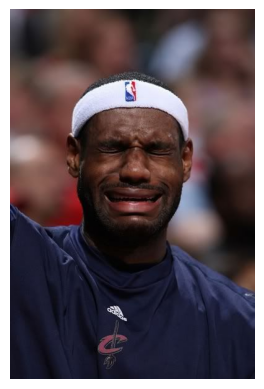

/content/emotional_face.jpg


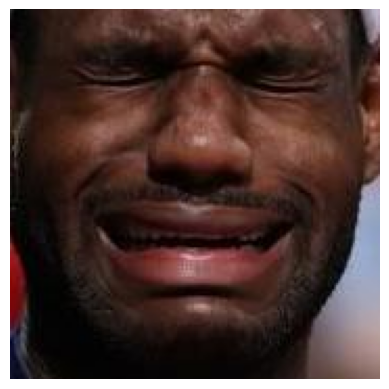

1/1 [==============================] - 0s 403ms/step
valence  -2.2232728  arousal  4.4108753


In [ ]:
#valence arousal estimation
import cv2
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt

img=plt.imread("/content/emotional_face.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

detect_face("/content","emotional_face.jpg")
# Define the path to the image

img_path = "/content/face_cropped.jpg" #"path/to/your/image"

try:
    img=plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = image.load_img(img_path, target_size=(96, 96), color_mode='grayscale')
except Exception as e:
    print("Error loading image:", e)
    exit(1)



x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

loaded_model_v = load_model('/content/drive/MyDrive/Emonet/models/vmodel1.h5')
loaded_model_a = load_model('/content/drive/MyDrive/Emonet/models/amodel1.h5')

loaded_model_v.compile(loss='mean_squared_error', optimizer='sgd')
loaded_model_a.compile(loss='mean_squared_error', optimizer='sgd')

prediction_v = loaded_model_v.predict(x)
prediction_a = loaded_model_a.predict(x)

print('valence ',prediction_v[0][0],' arousal ',prediction_a[0][0])

In [7]:
!pip install keras==3.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


/content/laughing_face.jpeg


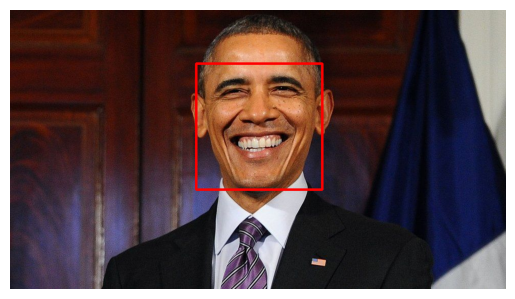

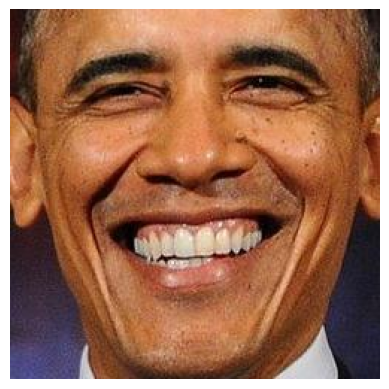

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
valence  1.6980839  arousal  3.8213239


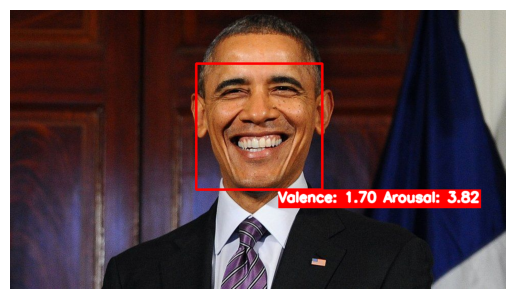

True

In [73]:
#valence arousal estimation
import cv2
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt

img_=plt.imread("/content/laughing_face.jpeg")
# plt.imshow(img_)
# plt.axis('off')
# plt.show()

x,y,w,h = detect_face("/content","laughing_face.jpeg")
cv2.rectangle(img_,(x,y),(x+w,y+h),(255,0,0),4)
plt.imshow(img_)
plt.axis('off')
plt.show()
# Define the path to the image

img_path = "/content/face_cropped.jpg" #"path/to/your/image"

try:
    img=plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = image.load_img(img_path, target_size=(96, 96), color_mode='grayscale')
except Exception as e:
    print("Error loading image:", e)
    exit(1)



x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

loaded_model_va = load_model('/content/drive/MyDrive/Emonet/models/vamodel.h5')
#loaded_model_a = load_model('/content/drive/MyDrive/Emonet/models/amodel2.h5')

loaded_model_va.compile(loss=['mean_squared_error','mean_squared_error'], optimizer='sgd')
#loaded_model_a.compile(loss='mean_squared_error', optimizer='sgd')

prediction_va = loaded_model_va.predict(x)
prediction_v = prediction_va[0][0][0]
prediction_a = prediction_va[1][0][0]

print('valence ',prediction_v,' arousal ',prediction_a)

# Add valence arousal values to the image
valence_arousal_text = f"Valence: {prediction_v:.2f} Arousal: {prediction_a:.2f}"
text_size, _ = cv2.getTextSize(valence_arousal_text, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 3)

# Draw filled background rectangle for valence arousal values
cv2.rectangle(img_, (img_.shape[1] - text_size[0] - 50, img_.shape[0] - text_size[1] - 175),
                  (img_.shape[1] - 50, img_.shape[0] - 160), (255, 0, 0), -1)

# Write valence arousal values in white color
cv2.putText(img_, valence_arousal_text, (img_.shape[1] - text_size[0] - 50, img_.shape[0] - 172),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 3, cv2.LINE_AA)

#img_with_values_rgb = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)

plt.imshow(img_)
plt.axis('off')
plt.show()
cv2.imwrite("visualized.png", cv2.cvtColor(img_,cv2.COLOR_BGR2RGB))

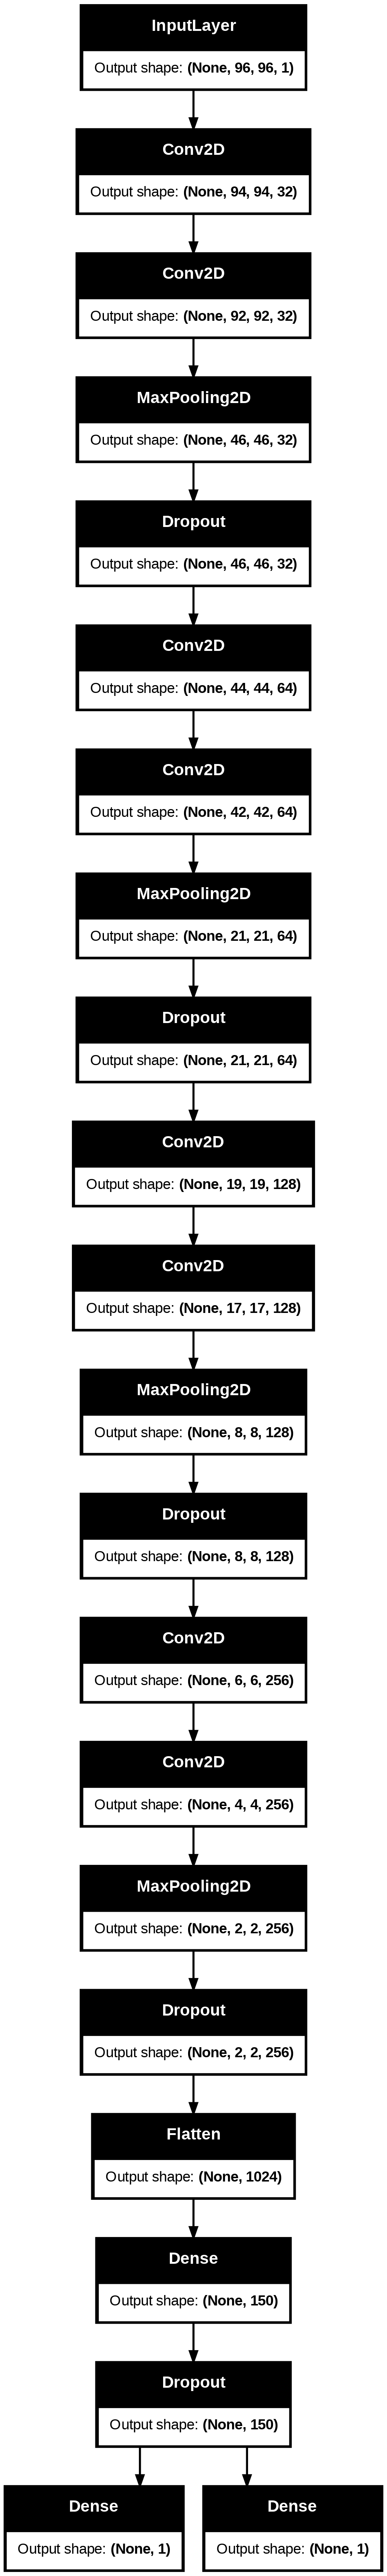

In [82]:
from tensorflow.keras.utils import plot_model

plot_model(loaded_model_va, to_file='model_plot.png', show_shapes=True)

In [83]:
loaded_model_va.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 94, 94, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 92, 92, 32)     │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 46, 46, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 46, 46, 32)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 44, 44, 64)     │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 42, 42, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 21, 21, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 21, 21, 64)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 19, 19, 128)    │         73,856 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 17, 17, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 8, 128)      │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 8, 8, 128)      │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 6, 6, 256)      │        295,168 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 4, 4, 256)      │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 2, 2, 256)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 2, 2, 256)      │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)    

 Total params: 1,325,732 (5.06 MB)

 Trainable params: 1,325,732 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
!apt install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [79]:
!pip install netron


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.0 MB/s eta 0:00:00


In [80]:
!netron /content/drive/MyDrive/Emonet/models/vamodel.h5

Serving '/content/drive/MyDrive/Emonet/models/vamodel.h5' at http://localhost:8081

Stopping http://localhost:8081
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/netron/server.py", line 261, in wait
    time.sleep(0.1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/netron", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/netron/__init__.py", line 36, in main
    wait()
  File "/usr/local/lib/python3.10/dist-packages/netron/server.py", line 264, in wait
    stop()
  File "/usr/local/lib/python3.10/dist-packages/netron/server.py", line 246, in stop
    thread.stop()
  File "/usr/local/lib/python3.10/dist-packages/netron/server.py", line 156, in stop
    self.terminate_event.wait(1000)
  File "/usr/lib/python3.10/threading.py", line 607, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.10/thr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("score = " + str(1 - model_a.evaluate(x_test_a, y_test_a)))

 29/199 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0913

W0000 00:00:1712002101.828811      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0949
score = 0.9049091637134552


In [ ]:
#valence arousal estimation
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

# Define the path to the image
img_path = "/kaggle/input/emodataset/Emodataset/train/ffhq_1.png" #"path/to/your/image"

try:
    img = image.load_img(img_path, target_size=(96, 96), color_mode='grayscale')
except Exception as e:
    print("Error loading image:", e)
    exit(1)

x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

#prediction_v = model_v.predict(x)
prediction_a = model_a.predict(x)

#print('valence ',prediction_v[0][0])
print(' arousal ',prediction_a[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 arousal  0.40689027


In [ ]:
# saving valence model to file
model_json_v = model_v.to_json()

json_file = open("/kaggle/working/affect_model_v.json", "w")
json_file.write(model_json_v)
json_file.close()

model_v.save_weights("/kaggle/working/affect_model_v.weights.h5")

In [ ]:
#valence arousal estimation
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

# Define the path to the image
img_path = "/kaggle/input/emodataset/Emodataset/test/ffhq_186.png" #"path/to/your/image"

try:
    img = image.load_img(img_path, target_size=(96, 96), color_mode='grayscale')
except Exception as e:
    print("Error loading image:", e)
    exit(1)

x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

json_file_v = open("/kaggle/working/affect_model_v.json", "r")
json_file_a = open("/kaggle/working/affect_model_a.json", "r")

loaded_model_json_v = json_file_v.read()
loaded_model_json_a = json_file_a.read()

json_file_v.close()
json_file_a.close()

loaded_model_v = model_from_json(loaded_model_json_v)
loaded_model_a = model_from_json(loaded_model_json_a)

loaded_model_v.load_weights("/kaggle/working/affect_model_v.weights.h5")
loaded_model_a.load_weights("/kaggle/working/affect_model_a.weights.h5")

loaded_model_v.compile(loss='mean_squared_error', optimizer='sgd')
loaded_model_a.compile(loss='mean_squared_error', optimizer='sgd')

prediction_v = loaded_model_v.predict(x)
prediction_a = loaded_model_a.predict(x)

print('valence ',prediction_v[0][0],' arousal ',prediction_a[0][0])
# Determine emotion based on predictions
# if -0.5 <= prediction_v <= 0.5 and prediction_a <= -0.66:
#     print("focus")
# elif -0.2 <= prediction_v <= 0 and -0.66 <= prediction_a <= 0:
#     print("relaxation")
# elif prediction_v <= 0 and prediction_a <= 0:
#     print("stress")
# elif 0 <= prediction_v <= 0.4 and 0 <= prediction_a <= 0.4:
#     print("interest")
# elif (0 <= prediction_v <= 0.7 and 0.4 <= prediction_a <= 0.7 or
#       0.4 <= prediction_v <= 0.7 and 0 <= prediction_a <= 0.4 or
#       0.7 <= prediction_v <= 1 and 0 <= prediction_a <= 1):
#     print("engagement")
# elif 0 <= prediction_v <= 1 and 0.7 <= prediction_a <= 1:
#     print("excitement")
# else:
#     print("Cannot determine emotion")


In [ ]:
# saving arousal model to file
model_json_a = model_a.to_json()

json_file = open("/kaggle/working/affect_model_a.json", "w")
json_file.write(model_json_a)
json_file.close()

model_a.save_weights("/kaggle/working/affect_model_a.weights.h5")